In [1]:
from datasets.datamodule import DEEPscreenDataModule
from engine.system import DEEPScreenClassifier
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd
import os
import glob

/big/lab/sjinich/che_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 02:58:40,569	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-21 02:58:40,670	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
data = pd.read_csv("../../.data/processed/antibiotics_test_predict.csv")
data

,Broad_ID,comp_id,smiles,Pred_Score,Mean_Inhibition,ClinTox (low = less predicted toxicity),Unnamed: 6
0,BRD-A20839672-003-01-5,cefmenoxime,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,"0,967200484871864","0,04505","0,00142176775261759",NaN
1,BRD-A61633223-001-02-8,ulifloxacin,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,"0,957036885619163","0,0504","0,958267450332641",NaN
2,BRD-K02275692-300-02-6,cefotiam,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,"0,952527394890785","0,04495","0,229828611016273",NaN
3,BRD-K96734425-304-01-7,ceftriaxone,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,"0,942159757018089","0,0425","0,0111461263149976",NaN
4,BRD-A47790386-001-03-6,balofloxacin,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,"0,931109279394149","0,04115","0,927146553993225",NaN
...,...,...,...,...,...,...,...
4491,BRD-K54142781-003-11-8,cirazoline,C(Oc1ccccc1C1CC1)C1=NCCN1,"0,000221521008828728","0,78324",NaN,NaN
4492,BRD-K81092066-311-01-6,phenacaine,CCOc1ccc(NC(C)=Nc2ccc(OCC)cc2)cc1,"0,000212054083450884","0,8019",NaN,NaN
4493,BRD-K10177585-003-02-4,PSB-11,CC[C@@H]1CN2C(=N1)c1[nH]c(nc1N(C)C2=O)-c1ccccc1,"0,000193477091748661","0,79578",NaN,NaN
4494,BRD-K91874254-001-01-4,CBS-1114,N=C(NNc1ccccc1)c1ccccc1,"0,000184610519958994","0,79896",NaN,NaN


In [3]:
## vamos con los 10 mejores
best_results = pd.read_pickle("/home/sjinich/disco/TrypanoDEEPscreen/.experiments/raytune_result_antibioticos_random_split_full_run.pkl")
best_results = best_results.sort_values(["val_mcc","val_recall"],ascending=False)
best_model = best_results.iloc[0,:]   
best_model_checkpoint = glob.glob(f"/home/sjinich/disco/TrypanoDEEPscreen/.experiments/antibioticos_hyperparameter_search/*{best_model['trial_id']}*/{best_model['checkpoint_dir_name']}/checkpoint.ckpt")[0]
trainer = Trainer()
model = DEEPScreenClassifier.load_from_checkpoint(best_model_checkpoint,experiment_result_path="../../.experiments/")
datamodule = DEEPscreenDataModule(data=data[["comp_id","smiles"]],batch_size=int(best_model["config/train_loop_config/batch_size"]),experiment_result_path="../../.experiments/",data_split_mode="predict",tmp_imgs=False)
result_pred = trainer.predict(model,datamodule=datamodule,return_predictions=True)
pd.concat(result_pred)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO: Using hyperparameters [('fully_layer_1', 32), ('fully_layer_2', 256), ('drop_rate', 0.3), ('learning_rate', 0.001), ('batch_size', 32), ('experiment_result_path', '../../.experiments/'), ('target', 'antibioticos_random_split_full_run')]
INFO: Using a total of 4496 datapoints
/big/lab/sjinich/che_env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 141/141 [00:37<00:00,  3.75it/s]


,comp_id,prediction,0_inactive_probability,1_active_probability
0,cefmenoxime,1,0.101195,0.898805
1,ulifloxacin,1,0.101195,0.898805
2,cefotiam,0,0.699573,0.300427
3,ceftriaxone,0,0.805804,0.194196
4,balofloxacin,0,0.984675,0.015325
...,...,...,...,...
11,cirazoline,0,0.999868,0.000132
12,phenacaine,0,0.999942,0.000058
13,PSB-11,0,0.999021,0.000979
14,CBS-1114,0,0.999963,0.000037


In [4]:
testing_prediction = pd.merge(data,pd.concat(result_pred),on="comp_id")
testing_prediction

,Broad_ID,comp_id,smiles,Pred_Score,Mean_Inhibition,ClinTox (low = less predicted toxicity),Unnamed: 6,prediction,0_inactive_probability,1_active_probability
0,BRD-A20839672-003-01-5,cefmenoxime,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,"0,967200484871864","0,04505","0,00142176775261759",NaN,1,0.101195,0.898805
1,BRD-A61633223-001-02-8,ulifloxacin,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,"0,957036885619163","0,0504","0,958267450332641",NaN,1,0.101195,0.898805
2,BRD-K02275692-300-02-6,cefotiam,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,"0,952527394890785","0,04495","0,229828611016273",NaN,0,0.699573,0.300427
3,BRD-K96734425-304-01-7,ceftriaxone,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,"0,942159757018089","0,0425","0,0111461263149976",NaN,0,0.805804,0.194196
4,BRD-A47790386-001-03-6,balofloxacin,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,"0,931109279394149","0,04115","0,927146553993225",NaN,0,0.984675,0.015325
...,...,...,...,...,...,...,...,...,...,...
4491,BRD-K54142781-003-11-8,cirazoline,C(Oc1ccccc1C1CC1)C1=NCCN1,"0,000221521008828728","0,78324",NaN,NaN,0,0.999868,0.000132
4492,BRD-K81092066-311-01-6,phenacaine,CCOc1ccc(NC(C)=Nc2ccc(OCC)cc2)cc1,"0,000212054083450884","0,8019",NaN,NaN,0,0.999942,0.000058
4493,BRD-K10177585-003-02-4,PSB-11,CC[C@@H]1CN2C(=N1)c1[nH]c(nc1N(C)C2=O)-c1ccccc1,"0,000193477091748661","0,79578",NaN,NaN,0,0.999021,0.000979
4494,BRD-K91874254-001-01-4,CBS-1114,N=C(NNc1ccccc1)c1ccccc1,"0,000184610519958994","0,79896",NaN,NaN,0,0.999963,0.000037


<Axes: title={'center': 'Fig. 2c con deepscreen'}, xlabel='Ranked molecules', ylabel='Prediction score'>

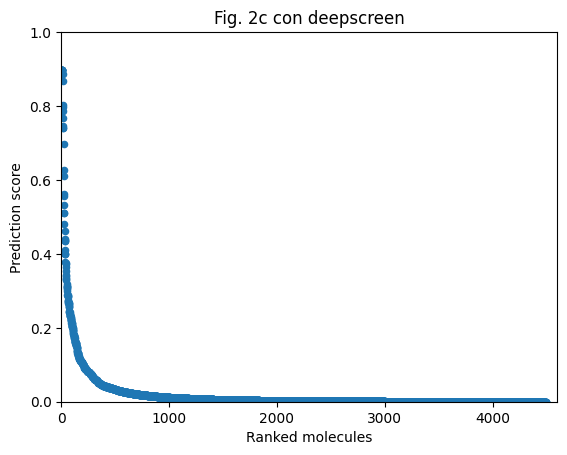

In [5]:
plot_2c = testing_prediction.sort_values("1_active_probability",ascending=False).reset_index()
plot_2c = plot_2c.reset_index()
plot_2c.plot(x="level_0",y="1_active_probability",kind="scatter",xlabel="Ranked molecules",ylabel="Prediction score",xlim=(0,4600),ylim=(0,1),title="Fig. 2c con deepscreen")

In [6]:
# halicina donde estasss!

plot_2c[plot_2c.comp_id == "SU3327"]

,level_0,index,Broad_ID,comp_id,smiles,Pred_Score,Mean_Inhibition,ClinTox (low = less predicted toxicity),Unnamed: 6,prediction,0_inactive_probability,1_active_probability
488,488,88,BRD-K32730239-001-02-8,SU3327,Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1,"0,331534500652924","0,05","3,01E-06",NaN,0,0.96547,0.03453


# Un intento de ensamble pero con los mejores modelos con distintos hyperparametros

In [8]:
## vamos con los 10 mejores
best_results = pd.read_pickle("/home/sjinich/disco/TrypanoDEEPscreen/.experiments/raytune_result_antibioticos_random_split_full_run.pkl")
best_results = best_results.sort_values(["val_mcc","val_recall"],ascending=False)
for i in range(20):
    best_model = best_results.iloc[i,:]   
    best_model_checkpoint = glob.glob(f"/home/sjinich/disco/TrypanoDEEPscreen/.experiments/antibioticos_random_split_full_run/*{best_model['trial_id']}*/{best_model['checkpoint_dir_name']}/checkpoint.ckpt")[0]
    trainer = Trainer()
    model = DEEPScreenClassifier.load_from_checkpoint(best_model_checkpoint,experiment_result_path="../../.experiments/")
    datamodule = DEEPscreenDataModule(data=data[["comp_id","smiles"]],target_id="antibiotics_predict",batch_size=int(best_model["config/train_loop_config/batch_size"]),experiment_result_path="../../.experiments/",data_split_mode="predict",tmp_imgs=False)
    trainer.predict(model,datamodule=datamodule)
    prediction_csv = "-".join(best_model[["config/train_loop_config/fully_layer_1","config/train_loop_config/fully_layer_2","config/train_loop_config/learning_rate","config/train_loop_config/drop_rate","config/train_loop_config/batch_size"]].astype(str).to_list())
    predictions = pd.read_csv(f"/home/sjinich/disco/TrypanoDEEPscreen/.experiments/predictions_antibioticos_random_split_full_run_{prediction_csv}.csv")
    predictions = predictions[["comp_id","prediction","1_active_probability"]]
    predictions = predictions.rename(columns={"prediction":f"prediction_{i}","1_active_probability":f"1_active_probability_{i}"})
    data = pd.merge(data,predictions,on="comp_id")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO: Using hyperparameters [('fully_layer_1', 32), ('fully_layer_2', 256), ('drop_rate', 0.3), ('learning_rate', 0.001), ('batch_size', 32), ('experiment_result_path', '../../.experiments/'), ('target', 'antibioticos_random_split_full_run')]
INFO: Using a total of 4496 datapoints


/big/lab/sjinich/che_env/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO: Using hyperparameters [('fully_layer_1', 128), ('fully_layer_2', 512), ('drop_rate', 0.3), ('learning_rate', 0.001), ('batch_size', 32), ('experiment_result_path', '../../.experiments/'), ('target', 'antibioticos_random_split_full_run')]
INFO: Using a total of 4496 datapoints


In [ ]:
data

,Broad_ID,name,smiles,Pred_Score,Mean_Inhibition,ClinTox (low = less predicted toxicity),Unnamed: 6,comp_id,prediction_0,1_active_probability_0,...,prediction_15,1_active_probability_15,prediction_16,1_active_probability_16,prediction_17,1_active_probability_17,prediction_18,1_active_probability_18,prediction_19,1_active_probability_19
0,BRD-A20839672-003-01-5,cefmenoxime,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,"0,967200484871864","0,04505","0,00142176775261759",NaN,comp0,1,0.898805,...,1,0.974892,0,1.363889e-01,1,0.993984,1,9.449378e-01,0,2.461282e-01
1,BRD-A61633223-001-02-8,ulifloxacin,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,"0,957036885619163","0,0504","0,958267450332641",NaN,comp1,1,0.898805,...,1,0.977811,1,9.999991e-01,1,0.973996,1,9.995409e-01,1,6.088062e-01
2,BRD-K02275692-300-02-6,cefotiam,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,"0,952527394890785","0,04495","0,229828611016273",NaN,comp2,0,0.300427,...,0,0.086989,0,1.092089e-01,0,0.050726,0,1.977016e-02,1,9.996809e-01
3,BRD-K96734425-304-01-7,ceftriaxone,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,"0,942159757018089","0,0425","0,0111461263149976",NaN,comp3,0,0.194196,...,0,0.021275,0,2.809198e-02,1,0.977103,1,8.104015e-01,0,2.194698e-01
4,BRD-A47790386-001-03-6,balofloxacin,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,"0,931109279394149","0,04115","0,927146553993225",NaN,comp4,0,0.015325,...,0,0.003721,0,2.269265e-03,0,0.237685,0,7.769228e-04,1,9.997833e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,BRD-K54142781-003-11-8,cirazoline,C(Oc1ccccc1C1CC1)C1=NCCN1,"0,000221521008828728","0,78324",NaN,NaN,comp4491,0,0.000132,...,0,0.000047,0,2.276643e-08,0,0.000007,0,1.883047e-06,0,4.073229e-07
4492,BRD-K81092066-311-01-6,phenacaine,CCOc1ccc(NC(C)=Nc2ccc(OCC)cc2)cc1,"0,000212054083450884","0,8019",NaN,NaN,comp4492,0,0.000058,...,0,0.000031,0,4.184192e-09,0,0.000039,0,1.941128e-05,0,1.997673e-03
4493,BRD-K10177585-003-02-4,PSB-11,CC[C@@H]1CN2C(=N1)c1[nH]c(nc1N(C)C2=O)-c1ccccc1,"0,000193477091748661","0,79578",NaN,NaN,comp4493,0,0.000979,...,0,0.001387,0,1.146786e-06,0,0.000006,0,2.689954e-05,0,2.067254e-04
4494,BRD-K91874254-001-01-4,CBS-1114,N=C(NNc1ccccc1)c1ccccc1,"0,000184610519958994","0,79896",NaN,NaN,comp4494,0,0.000037,...,0,0.000010,0,1.836911e-08,0,0.000012,0,1.471969e-07,0,1.291188e-09


In [ ]:
data

In [26]:
ensambled_prob_columns = [f"1_active_probability_{str(i)}" for i in range(1)]

data["ensambled_deepscreen_score"] = data.apply(lambda x: x[ensambled_prob_columns].mean(),axis=1)

data[["name","smiles","Pred_Score","Mean_Inhibition","ensambled_deepscreen_score"]].head(60)

,name,smiles,Pred_Score,Mean_Inhibition,ensambled_deepscreen_score
0,cefmenoxime,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,"0,967200484871864","0,04505",0.898805
1,ulifloxacin,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,"0,957036885619163","0,0504",0.898805
2,cefotiam,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,"0,952527394890785","0,04495",0.300427
3,ceftriaxone,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,"0,942159757018089","0,0425",0.194196
4,balofloxacin,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,"0,931109279394149","0,04115",0.015325
5,cefminox,CO[C@]1(NC(=O)CSC[C@@H](N)C(O)=O)[C@H]2SCC(CSc...,"0,931014075875282","0,7304",0.157857
6,danofloxacin,CN1C[C@@H]2C[C@H]1CN2c1cc2n(cc(C(O)=O)c(=O)c2c...,"0,928766921907663","0,0452",0.898805
7,besifloxacin,N[C@@H]1CCCCN(C1)c1c(F)cc2c(c1Cl)n(cc(C(O)=O)c...,"0,928699716925621","0,041",0.221351
8,cefazolin,Cc1nnc(SCC2=C(N3[C@H](SC2)[C@H](NC(=O)Cn2cnnn2...,"0,927870696783065","0,5969",0.372874
9,cefodizime,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(C)c(CC(O)...,"0,92321006655693","0,04205",0.083494


In [27]:
data[["name","smiles","Pred_Score","Mean_Inhibition","ensambled_deepscreen_score"]].tail(50)

,name,smiles,Pred_Score,Mean_Inhibition,ensambled_deepscreen_score
4446,3-indolebutyric-acid,OC(=O)CCCc1c[nH]c2ccccc12,"0,000675186051802256","0,79668",2.199327e-03
4447,fosfosal,OC(=O)c1ccccc1OP(O)(O)=O,"0,000668567091423852","0,81594",1.783484e-03
4448,GSK-37647,COc1ccc(cc1)S(=O)(=O)Nc1c(C)cc(C)cc1C,"0,000667012317666326","0,82452",1.947658e-04
4449,BAY-11-7085,CC(C)(C)c1ccc(cc1)S(=O)(=O)\C=C\C#N,"0,000663306399306679","0,78672",3.793995e-07
4450,naratriptan,CNS(=O)(=O)CCc1ccc2[nH]cc(C3CCN(C)CC3)c2c1,"0,000660079576186944","0,81012",2.040462e-03
4451,PF-06447475,N#Cc1cccc(c1)-c1c[nH]c2ncnc(N3CCOCC3)c12,"0,000631775579172266","0,8157",1.815701e-03
4452,ABT-239,C[C@@H]1CCCN1CCc1cc2cc(ccc2o1)-c1ccc(cc1)C#N,"0,000616737178202547","0,80898",1.188196e-04
4453,SB-203186,O=C(OCCN1CCCCC1)c1c[nH]c2ccccc12,"0,000613866404239615","0,81426",2.525315e-05
4454,VP-20629,OC(=O)CCc1c[nH]c2ccccc12,"0,00060588038197693","0,8031",2.752400e-04
4455,diarylpropionitrile,Oc1ccc(CC(C#N)c2ccc(O)cc2)cc1,"0,000600455762934968","0,78612",4.521683e-05
